# **Part 3c:** Classification with Single Neurons

In [1]:
# Public libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from sklearn import linear_model
from tqdm.notebook import tqdm

# Local libraries
import tools.classification as cl
import tools.evaluation as ev

## Parameters

In [2]:
digits = ['zero','oh', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

select_digits = ['one', 'four', 'six', 'eight']

num_words = len(digits)

dirnames = ['Results/TIDIGITS/layer_1/e-i/w0.5_tau0.5_dmax3/formants/',
            'Results/TIDIGITS/layer_1/e-i/w0.5_tau0.5_dmax3/output/',
            'Results/TIDIGITS/layer_1/tde/output/',
            'Results/TIDIGITS/layer_2/e-i/']

dir_inds = [[0],
            [1],
            [2],
            [3]
]

num_neur = [32, 174, 180, 156]

labels = ["Formants",
          "E-I layer 1",
          "TDEs",
          "E-I layer 2"]

x_labels = ['z', 'o', '1', '2', '3', '4', '5', '6', '7', '8', '9']

best_neurons = np.loadtxt('best_neurons.csv', delimiter=',')

## Train and Test Classifier

In [3]:
num_layers = len(dirnames)
num_digits = len(digits)

# Result arrays
scores_test = np.zeros((num_layers, num_digits))
delta = np.zeros((num_layers, num_digits))
tpr = np.zeros((num_layers, num_digits))
tnr = np.zeros((num_layers, num_digits))

tps = {}

count_mean = np.zeros((num_layers, num_digits))
count_std = np.zeros((num_layers, num_digits))

# Loop over network layers
for i in tqdm(range(len(dirnames)), desc='Layers'):

    tps[i] = {}

    # Get names of directories
    dirs = []
    for ind in dir_inds[i]:
        dirs.append(dirnames[ind])

    # Loop over keywords
    for j, keyword in enumerate(tqdm(digits, desc='Keywords')):

        # Get keyword index
        kw_ind = digits.index(keyword)
            
        score_train = 0    
        
        # Get best neuron
        neuron_id = int(best_neurons[i,j])
        
        feature_inds = [neuron_id]
        
        # Create classification model
        model = linear_model.LogisticRegression(solver = 'liblinear',
                                                multi_class = 'ovr')
        
        # Train model
        score_train = cl.train(model, feature_inds, kw_ind, num_words, dirs, scale_data=False)
        
        # Test model
        scores_test[i,j], tpr[i,j], tnr[i,j], tps[i][j] = cl.test(model, feature_inds, kw_ind, num_words, dirs, scale_data=False)
        
        # Get average spike-count for neuron
        count_mean[i,j], count_std[i,j] = ev.count_per_sample(neuron_id, kw_ind, num_words, dirnames[i])
        
    delta[i,:] = scores_test[i,:] - scores_test[0,:]

Layers:   0%|          | 0/4 [00:00<?, ?it/s]

Keywords:   0%|          | 0/11 [00:00<?, ?it/s]

Keywords:   0%|          | 0/11 [00:00<?, ?it/s]

Keywords:   0%|          | 0/11 [00:00<?, ?it/s]

Keywords:   0%|          | 0/11 [00:00<?, ?it/s]

In [9]:
print(max(delta[0,:]))
print(max(delta[1,:]))
print(max(delta[2,:]))
print(max(delta[3,:]))

print()
print(digits[np.argmax(delta[1,:])])
print(digits[np.argmax(delta[2,:])])
print(digits[np.argmax(delta[3,:])])

print()
print(max(delta[0,:]))
print(min(delta[1,:]))
print(min(delta[2,:]))
print(min(delta[3,:]))

0.0
0.030701754385964897
0.0635964912280702
0.04166666666666663

eight
seven
zero

0.0
-0.0328947368421052
-0.10745614035087714
-0.04824561403508776


### Store Results

In [6]:
#np.savetxt('trainscores_best_neuron.csv', trainscores, delimiter=',')
#np.savetxt('testscores_best_neuron.csv', testscores, delimiter=',')
#np.savetxt('best_neurons.csv', best_neurons, delimiter=',')

pickle.dump(tps, open('true_positive_samples.p', 'wb'))

## Plots

### Load Data

In [5]:
#trainscores = np.loadtxt('trainscores_best_neuron.csv', delimiter=',')
#testscores = np.loadtxt('testscores_best_neuron.csv', delimiter=',')

### Accuracy Plot

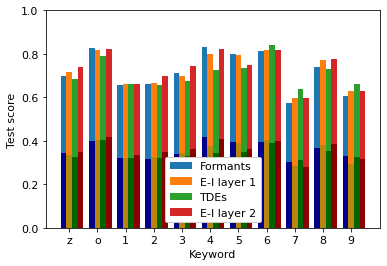

In [6]:
colors_standard = ['C0', 'C1', 'C2', 'C3']
colors_light = ['lightblue', 'gold', 'lightgreen', 'lightcoral']
colors_dark = ['darkblue', 'darkgoldenrod', 'darkgreen', 'darkred']

# Set figure font-size
plt.rcParams['font.size'] = '11'

# Set width of barplots
barwidth = 1 / (len(dirnames) + 1)

# Reset x axis
x = np.arange(len(digits))
plt.figure()

# Loop over barplots
for i in range(len(dir_inds)):
    
    # Update x axis
    x = [k + barwidth for k in x]
    
    # Create barplot
    plt.bar(x, (tpr+tnr)[i,:], width=barwidth,
            label=labels[i],
            color=colors_standard[i]
    )
    
    plt.bar(x, tnr[i,:], width=barwidth,
            #label = labels[i],
            color = colors_dark[i]
    )

# Format figure
plt.xlabel("Keyword")
plt.ylabel("Test score")
plt.ylim(0, 1)
plt.xticks([r + 2*barwidth for r in range(len(digits))], x_labels)
plt.legend(loc = 'lower center',
           framealpha = 1
)

In [ ]:
plt.savefig('Figures/best_neuron_test.pdf')

### Spikes-Count Per Sample

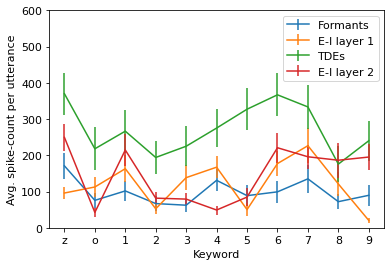

In [12]:
# Set figure font-size
plt.rcParams['font.size'] = '11'

# Reset x axis
x = np.arange(len(digits))
plt.figure()

# Loop over barplots
for i in range(len(dir_inds)):
    
    plt.errorbar(x, count_mean[i,:], count_std[i,:], label=labels[i])

# Format figure
plt.xlabel("Keyword")
plt.ylabel("Avg. spike-count per utterance")
plt.xticks([r for r in range(len(digits))], x_labels)
plt.legend()
plt.ylim(0, 600)

In [ ]:
plt.savefig('Figures/mean_spike-counts.pdf')

### Accuracy Per Spike

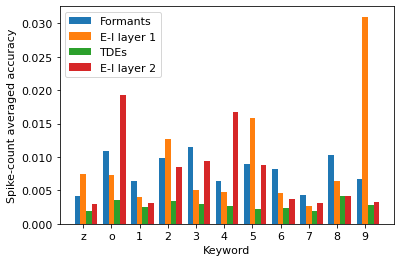

In [15]:
# Set figure font-size
plt.rcParams['font.size'] = '11'

# Set width of barplots
barwidth = 1 / (len(dirnames) + 1)

# Reset x axis
x = np.arange(len(digits))
plt.figure()

# Loop over barplots
for i in range(len(dir_inds)):
    
    # Update x axis
    x = [k + barwidth for k in x]
    
    # Create barplot
    plt.bar(x, scores_test[i,:]/count_mean[i,:], width=barwidth, label=labels[i])

# Format figure
plt.xlabel("Keyword")
plt.ylabel("Spike-count averaged accuracy")
#plt.ylim(0, 1)
plt.xticks([r + 2*barwidth for r in range(len(digits))], x_labels)
plt.legend()

In [ ]:
#plt.savefig('Figures/best_neuron_test.pdf')

### TPR vs. TNR

([<matplotlib.axis.XTick at 0x7fb17313bf90>,
 [Text(0.4, 0, 'z'),
  Text(1.4, 0, 'o'),
  Text(2.4, 0, '1'),
  Text(3.4, 0, '2'),
  Text(4.4, 0, '3'),
  Text(5.4, 0, '4'),
  Text(6.4, 0, '5'),
  Text(7.4, 0, '6'),
  Text(8.4, 0, '7'),
  Text(9.4, 0, '8'),
  Text(10.4, 0, '9')])

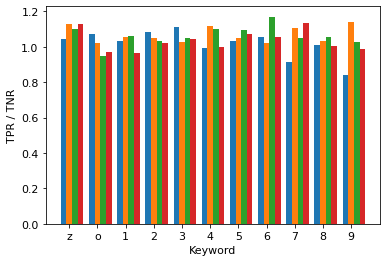

In [7]:
# Reset x axis
x = np.arange(len(digits))
plt.figure()

# Loop over barplots
for i in range(len(dir_inds)):
    
    # Update x axis
    x = [k + barwidth for k in x]
    
    # Create barplot
    plt.bar(x, (tpr/tnr)[i,:], width=barwidth,)

# Format figure
plt.xlabel("Keyword")
plt.ylabel("TPR / TNR")
#plt.ylim(0, 1)
plt.xticks([r + 2*barwidth for r in range(len(digits))], x_labels)
#plt.legend(loc='upper right')
    
#plt.savefig('Figures/best_neuron_test.pdf')

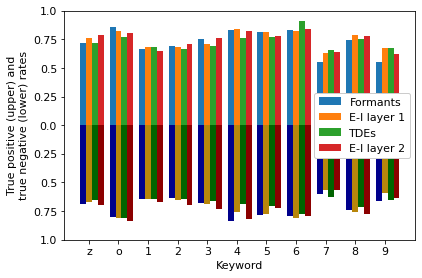

In [16]:
# Reset x axis
x = np.arange(len(digits))
plt.figure()

# Loop over barplots
for i in range(len(dir_inds)):
    
    # Update x axis
    x = [k + barwidth for k in x]
    
    # Create barplot
    plt.bar(x, 2*tpr[i,:], width=barwidth,
            label=labels[i],
            color=colors_standard[i]
    )
    
    plt.bar(x, -2*tnr[i,:], width=barwidth,
            #label = labels[i],
            color = colors_dark[i]
    )

# Format figure
plt.xlabel("Keyword")
plt.ylabel("True positive (upper) and\ntrue negative (lower) rates")
plt.ylim(-1, 1)
plt.xticks([r + 2*barwidth for r in range(len(digits))], x_labels)
plt.legend(
        loc = 'center right',
        framealpha = 1
)

# Use absolute value for y-ticks
tick_locs, tick_labels =  plt.yticks()
plt.yticks(tick_locs,
           [abs(tick) for tick in tick_locs]
)

plt.tight_layout()
    
plt.savefig('Figures/best_neuron_tp_tn.pdf')